# Processing annotated variant files

The script will process each annotated variant file and output the processed file along with several summary statistics. The summary statistics include read depth summary, filtration summary, and functional location and effect of called variants.

The pipeline is run once for all replcates and then again, with different filtering criteria, for the concatenated variant files.

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
class process_variants():
    """
    Process summary statistics and filter variants for input file
    
    Usage:
            variant_object = process_variants(<filename>)

    Methods act on annotated variant dataframes
    
    Filter variants based on low and high read depth and minor allele frequency
    Also output summary files including the functional location distribution (e.g. exon),
    the read depth summary, and mutation classification (e.g. frameshift)
    """
    
    def __init__(self, variant_file, filter_min_depth=10, filter_max_depth=800,
                 filter_common_maf=0.05):
        """
        Initialize process_variants() class
        
        Arguments:
        variant_file - location of a variant file
        filter_min_depth - in processed file output, remove all variants with depth below
        filter_max_depth - in processed file output, remove all variants with depth above
        filter_common_maf - in processed file output, remove all variants with MAF above
        """
        self.variant_file = variant_file
        self.sample_name = os.path.basename(self.variant_file).split('.')[0]
        self.filter_min_depth = filter_min_depth
        self.filter_max_depth = filter_max_depth
        self.filter_common_maf = filter_common_maf
        self.variant_df = pd.read_csv(self.variant_file)
        self.all_variant_count = self.variant_df.shape[0]
        
    def _process_depth(self):
        """
        Private method to extract read depth from each variant
        """
        other_info_list = self.variant_df['Otherinfo'].str.split('\t').tolist()
        depth_info_df = pd.DataFrame(other_info_list, columns=['het', 'quality', 'depth'])
        self.variant_df.index = depth_info_df.index
        self.variant_df = pd.concat([self.variant_df, depth_info_df], axis=1)
    
    def filter_depth(self):
        """
        Method to remove variants with low and high depth beyond initialized threshold

        Also stores the resulting variant file following the specific filtration step
        """
        # Filter min depth
        self._process_depth()
        self.variant_df = (
            self.variant_df[self.variant_df['depth'].astype(int) >= self.filter_min_depth]
            )
        self.filter_min_depth_count = self.variant_df.shape[0]
        
        # Filter max depth
        self.variant_df = (
            self.variant_df[self.variant_df['depth'].astype(int) <= self.filter_max_depth]
            )
        self.filter_max_depth_count = self.variant_df.shape[0]
        
    def filter_common_variation(self):
        """
        Method to remove common variants based on minor allele frequency.

        First separates the variant file between known and unknown MAF,then removes variants
        that are greater than the theshold MAF. The final variant file includes variants with
        less than common MAF plus all unknown MAFs.
        
        Also stores the number of unknown variants and the number of common variants filtered.
        """
        # Filter common variation
        #unknown_freq_df = self.variant_df[self.variant_df['gnomAD_exome_ALL'] == '.']
        unknown_freq_df = self.variant_df.query('gnomAD_exome_ALL == "."')
        #other_freq_df = self.variant_df[self.variant_df['gnomAD_exome_ALL'] != '.']
        other_freq_df = self.variant_df.query('gnomAD_exome_ALL != "."')
        self.unknown_maf_count = unknown_freq_df.shape[0]
       
        # Filter common variants
        other_freq_df = other_freq_df[other_freq_df['gnomAD_exome_ALL'].astype(float) <= filter_common_maf]
        self.variant_df = pd.concat([other_freq_df, unknown_freq_df], axis=0)
        self.filter_common_var_count = self.variant_df.shape[0]
        
    def plot_depth(self, bins=100):
        """
        Method to plot a histogram of variant depths
        
        Arguments:
        bins - how many bins to draw in the seaborn distplot
        """
        sns.set(font_scale=1.5)
        sns.set_style('whitegrid')
        g = sns.distplot(self.variant_df['depth'].astype(float), bins=bins)
        g.set_title('Read Depth Distribution for {}'.format(self.sample_name))
    
    def get_summary_statistics(self):
        """
        Method to summarize processed variant files
        
        Returns functional, mutational, read depth, and cosmic counts.
        Also stores log10 mutation count for processed variant file and file with all cosmic variants
        """
        # Get log 10 total mutation count
        self.log_mut_count = np.log10(self.variant_df.shape[0])

        # Get the number of variants stratified by functional location of variant
        # E.g. Exon, Intron, 5'UTR, etc.
        self.functional_counts = pd.DataFrame(self.variant_df['Func.refGene'].value_counts())
        self.functional_counts.columns = [self.sample_name]
        
        # Get the number of variants stratified by exonic functional outcome of variant
        # E.g. Silent, Nonsense, Missense, etc.
        self.mutational_class_counts = (
            pd.DataFrame(self.variant_df['ExonicFunc.refGene'].value_counts())
            )
        self.mutational_class_counts.columns = [self.sample_name]
        
        # Get number of COSMIC curated events
        self.cosmic_variants = self.variant_df[self.variant_df['cosmic70'] != '.']
        self.cosmic_variants = self.cosmic_variants.assign(sample_name = self.sample_name)
        self.cosmic_variant_counts = self.cosmic_variants.shape[0]
        
        # Get depth summary
        self.depth_summary = pd.DataFrame(self.variant_df['depth'].astype(int).describe())
        self.depth_summary.columns = [self.sample_name]
        
        return self.functional_counts, self.mutational_class_counts, self.depth_summary

    def curate_filter_info(self):
        """
        Method to extract internal processed data
        """
        filter_list = [
            self.sample_name, self.all_variant_count,
            self.filter_min_depth_count, self.filter_max_depth_count,
            self.filter_common_var_count, self.log_mut_count,
            self.cosmic_variant_counts, self.unknown_maf_count
        ]
        return filter_list
    
    def output_processed_data(self, out_dir, cosmic_file=False):
        """
        Method to write all processed variants to file (final variants to analyze downstream)
        
        Arguments:
        outdir - directory of where the file should be written
        cosmic_file - boolean if file written is the cosmic variants. Will not write both files
        """
        if cosmic_file:
            out_file = os.path.join(out_dir,
                                    '{}_cosmic_variants.tsv.bz2'.format(self.sample_name))
            self.cosmic_variants.to_csv(out_file, sep='\t', compression='bz2')
        else:
            out_file = os.path.join(out_dir,
                                    '{}_processed_variants.tsv.bz2'.format(self.sample_name))
            self.variant_df.to_csv(out_file, sep='\t', compression='bz2')
        

## Process Replicates - Four Technical Replicates per Sample

In [4]:
filter_common_maf = 0.05
replicate_filter_min_depth_count = 10
replicate_filter_max_depth_count = 800

In [5]:
# Process variant results
variant_file_path = os.path.join('results', 'annotated_vcfs')
processed_file_path = os.path.join('results', 'processed_vcfs')
cosmic_file_path = os.path.join('results', 'cosmic_vcfs')

filter_info_all = []
functional_counts_all = []
mutational_counts_all = []
depth_summary_all = []

for variant_file in os.listdir(variant_file_path):
    full_variant_file = os.path.join(variant_file_path, variant_file)

    variant_info = process_variants(full_variant_file,
                                    filter_min_depth=replicate_filter_min_depth_count,
                                    filter_max_depth=replicate_filter_max_depth_count,
                                    filter_common_maf=filter_common_maf)

    variant_info.filter_common_variation()
    variant_info.filter_depth()

    func_count, mut_count, depth_summary = variant_info.get_summary_statistics()
    filter_info_all.append(variant_info.curate_filter_info())
    
    functional_counts_all.append(func_count)
    mutational_counts_all.append(mut_count)
    depth_summary_all.append(depth_summary)
    
    fig_file = os.path.join('figures', 'read_depth', 'replicates',
                            '{}_depth_distrib.pdf'.format(variant_info.sample_name))
    variant_info.plot_depth()
    plt.savefig(fig_file)
    plt.close()
    
    # Save processed output file
    variant_info.output_processed_data(out_dir=processed_file_path)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
# Save summary statistics for the replicate data

# Save read depth summary results
depth_output_file = os.path.join('results', 'replicates_full_depth_summary.tsv')
depth_df = pd.concat(depth_summary_all, axis=1).fillna(0).astype(int).T.sort_index()
depth_df.to_csv(depth_output_file, sep='\t')

# Save mutation count summary results
mut_count_output_file = os.path.join('results', 'replicates_full_mutation_count_summary.tsv')
mutational_counts_df = (
    pd.concat(mutational_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
    )
mutational_counts_df.to_csv(mut_count_output_file, sep='\t')

# Save functional genomics summary results
func_count_output_file = os.path.join('results', 'replicates_full_functional_count_summary.tsv')
functional_counts_df = (
    pd.concat(functional_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
    )
functional_counts_df.to_csv(func_count_output_file, sep='\t')

In [7]:
# Process functional filtration summary
filter_count_output_file = os.path.join('results', 'replicates_filter_summary.tsv')
filter_counts_df = pd.DataFrame(filter_info_all,
                                columns=['sample_name', 'all_variant_count',
                                         'filter_min_depth_count', 'filter_max_depth_count',
                                         'filter_common_var_count','log_mut_count',
                                         'COSMIC_count', 'unknown_maf']).sort_values(by='sample_name')

filter_counts_df = (
    filter_counts_df
    .assign(base_sample = [x[0] for x in filter_counts_df['sample_name'].str.split('_')])
    )
filter_counts_df = (
    filter_counts_df
    .assign(lane = [x[2] for x in filter_counts_df['sample_name'].str.split('_')])
    )

filter_counts_df['log_mut_count'] = round(filter_counts_df['log_mut_count'], 2)

filter_counts_df.to_csv(filter_count_output_file, sep='\t', index=False)

In [8]:
filter_melt_df = (
    filter_counts_df.melt(id_vars=['base_sample', 'lane', 'sample_name',
                                   'log_mut_count', 'COSMIC_count'],
                          value_vars=['all_variant_count', 'filter_min_depth_count',
                                      'filter_max_depth_count', 'filter_common_var_count',
                                      'unknown_maf'],
                          var_name='num_variants', value_name='filtration')
    )
# Max and Min depth is nearly the same, filter max
filter_melt_df = filter_melt_df.query('num_variants != "filter_max_depth_count"')
filter_melt_df = filter_melt_df.sort_values(by='filtration')
filter_melt_df.head(3)

,base_sample,lane,sample_name,log_mut_count,COSMIC_count,num_variants,filtration
197,030-F5,L002,030-F5_S6_L002_001,3.34,33,filter_min_depth_count,2177
199,030-F5,L004,030-F5_S6_L004_001,3.35,21,filter_min_depth_count,2246
198,030-F5,L003,030-F5_S6_L003_001,3.36,29,filter_min_depth_count,2303


### Visualize summary statistics across replicates

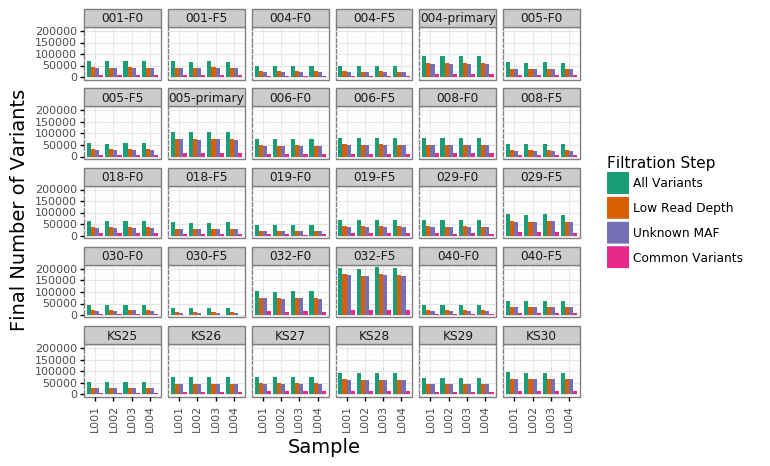

<ggplot: (-9223363260771725231)>

In [9]:
# Reorder plotting variables
filter_list = ['all_variant_count', 'filter_common_var_count',
               'unknown_maf', 'filter_min_depth_count']
filter_list_cat = CategoricalDtype(categories=filter_list, ordered=True)
filter_melt_df['num_variants_cat'] = (
    filter_melt_df['num_variants'].astype(str).astype(filter_list_cat)
    )

p = (
    gg.ggplot(filter_melt_df,
              gg.aes(x='lane', y='filtration', fill='num_variants_cat')) +
    gg.geom_bar(stat='identity', position='dodge') +
    gg.facet_wrap('~ base_sample') +
    gg.scale_fill_manual(name='Filtration Step',
                         values=['#1b9e77', '#d95f02', '#7570b3', '#e7298a'],
                         labels=['All Variants',
                                 'Low Read Depth',
                                 'Unknown MAF',
                                 'Common Variants']) + 
    gg.xlab('Sample') +
    gg.ylab('Final Number of Variants') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [10]:
figure_file = os.path.join('figures', 'replicates_filtration_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.5 x 5.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: figures/replicates_filtration_results.pdf
  warn('Filename: {}'.format(filename))


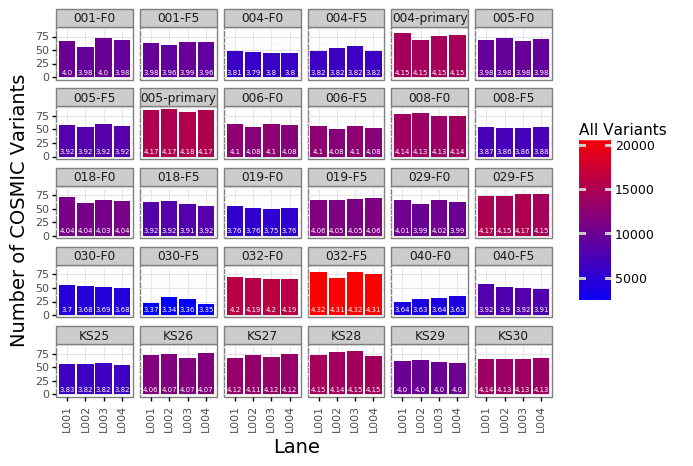

<ggplot: (-9223363260771017051)>

In [11]:
p = (
    gg.ggplot(filter_counts_df,
              gg.aes(x='lane', y='COSMIC_count', fill='filter_min_depth_count')) +
    gg.geom_bar(stat='identity', position='dodge') +
    gg.geom_text(gg.aes(y=10, label='log_mut_count'), size=5, colour='white') +
    gg.scale_fill_gradient(low='blue', high='red', name='All Variants') + 
    gg.facet_wrap('~ base_sample') +
    gg.xlab('Lane') +
    gg.ylab('Number of COSMIC Variants') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [12]:
figure_file = os.path.join('figures', 'replicates_cosmic_mutcount_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.5 x 5.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: figures/replicates_cosmic_mutcount_results.pdf
  warn('Filename: {}'.format(filename))


## Process Merged Files - These are the Final VCFs to Interpret

In [13]:
filter_common_maf = 0.05
merged_filter_min_depth_count = 15
merged_filter_max_depth_count = 1000

In [14]:
# Process variant results
variant_file_path = os.path.join('results', 'annotated_merged_vcfs')
processed_file_path = os.path.join('results', 'processed_merged_vcfs')

filter_info_all = []
functional_counts_all = []
mutational_counts_all = []
depth_summary_all = []
cosmic_dfs = []

for variant_file in os.listdir(variant_file_path):
    full_variant_file = os.path.join(variant_file_path, variant_file)

    variant_info = process_variants(full_variant_file,
                                    filter_min_depth=merged_filter_min_depth_count,
                                    filter_max_depth=merged_filter_max_depth_count,
                                    filter_common_maf=filter_common_maf)

    variant_info.filter_common_variation()
    variant_info.filter_depth()

    func_count, mut_count, depth_summary = variant_info.get_summary_statistics()
    filter_info_all.append(variant_info.curate_filter_info())
    
    functional_counts_all.append(func_count)
    mutational_counts_all.append(mut_count)
    depth_summary_all.append(depth_summary)
    
    fig_file = os.path.join('figures', 'read_depth',
                            '{}_depth_distrib.pdf'.format(variant_info.sample_name))
    variant_info.plot_depth()
    plt.savefig(fig_file)
    plt.close()
    
    # Save processed output file
    variant_info.output_processed_data(out_dir=processed_file_path)
    
    # Build list of all cosmic variant dataframes
    cosmic_dfs.append(variant_info.cosmic_variants)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [15]:
# Save read depth summary results
depth_output_file = os.path.join('results', 'merged_full_depth_summary.tsv')
depth_df = pd.concat(depth_summary_all, axis=1).fillna(0).astype(int).T.sort_index()
depth_df.to_csv(depth_output_file, sep='\t')

In [16]:
# Save mutation count summary results
mut_count_output_file = os.path.join('results', 'merged_full_mutation_count_summary.tsv')
mutational_counts_df = (
    pd.concat(mutational_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
    )
mutational_counts_df.to_csv(mut_count_output_file, sep='\t')

In [17]:
# Save functional genomics summary results
func_count_output_file = os.path.join('results', 'merged_full_functional_count_summary.tsv')
functional_counts_df = (
    pd.concat(functional_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
    )
functional_counts_df.to_csv(func_count_output_file, sep='\t')

In [18]:
filter_count_output_file = os.path.join('results', 'merged_filter_summary.tsv')
filter_counts_df = pd.DataFrame(filter_info_all,
                                columns=['sample_name', 'all_variant_count',
                                         'filter_min_depth_count', 'filter_max_depth_count',
                                         'filter_common_var_count','log_mut_count',
                                         'COSMIC_count', 'unknown_maf']).sort_values(by='sample_name')

filter_counts_df['log_mut_count'] = round(filter_counts_df['log_mut_count'], 2)

filter_counts_df.to_csv(filter_count_output_file, sep='\t', index=False)

In [19]:
# Generate a dataframe of all observed COSMIC variants
cosmic_output_file = os.path.join('results', 'all_cosmic_variants.tsv')
all_cosmic_dfs = pd.concat(cosmic_dfs, axis=0)
print(all_cosmic_dfs.shape)
all_cosmic_dfs.to_csv(cosmic_output_file, sep='\t', index=False)

(3120, 59)


In [20]:
filter_melt_df = (
    filter_counts_df.melt(id_vars=['sample_name',
                                   'log_mut_count', 'COSMIC_count'],
                          value_vars=['all_variant_count', 'filter_min_depth_count',
                                      'filter_max_depth_count', 'filter_common_var_count',
                                      'unknown_maf'],
                          var_name='num_variants', value_name='filtration')
    )

# Max and Min depth is nearly the same, filter max
filter_melt_df = filter_melt_df.query('num_variants != "filter_max_depth_count"')
filter_melt_df = filter_melt_df.sort_values(by='filtration')
filter_melt_df.head()

,sample_name,log_mut_count,COSMIC_count,num_variants,filtration
49,030-F5,3.88,80,filter_min_depth_count,7661
52,040-F0,4.08,78,filter_min_depth_count,12110
48,030-F0,4.12,81,filter_min_depth_count,13252
44,019-F0,4.18,99,filter_min_depth_count,14971
32,004-F0,4.19,88,filter_min_depth_count,15441


### Visualize summary statistics for merged data

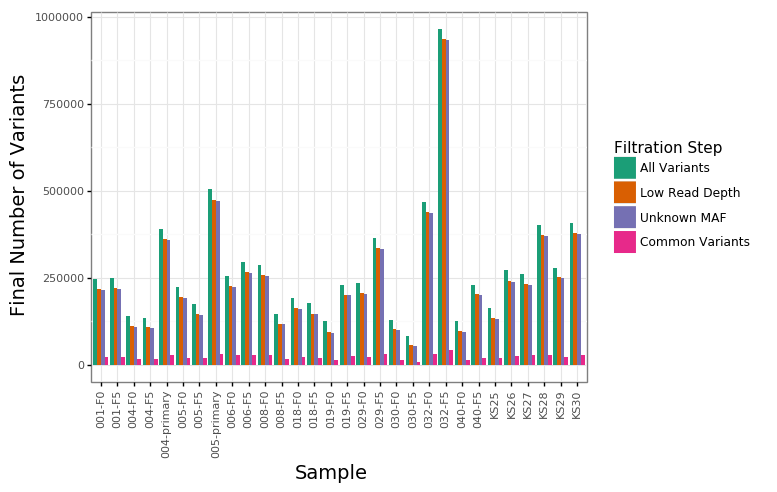

<ggplot: (8776079055343)>

In [21]:
# Reorder Plotting Variables
filter_list = ['all_variant_count', 'filter_common_var_count',
               'unknown_maf', 'filter_min_depth_count']
filter_list_cat = CategoricalDtype(categories=filter_list, ordered=True)
filter_melt_df['num_variants_cat'] = (
    filter_melt_df['num_variants'].astype(str).astype(filter_list_cat)
    )

p = (
    gg.ggplot(filter_melt_df,
              gg.aes(x='sample_name', y='filtration', fill='num_variants_cat')) +
    gg.geom_bar(stat='identity', position='dodge') +
    gg.theme_bw() +
    gg.scale_fill_manual(name='Filtration Step',
                         values=['#1b9e77', '#d95f02', '#7570b3', '#e7298a'],
                         labels=['All Variants',
                                 'Low Read Depth',
                                 'Unknown MAF',
                                 'Common Variants']) + 
    gg.xlab('Sample') +
    gg.ylab('Final Number of Variants') +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [22]:
figure_file = os.path.join('figures', 'merged_filtration_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.5 x 5.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: figures/merged_filtration_results.pdf
  warn('Filename: {}'.format(filename))


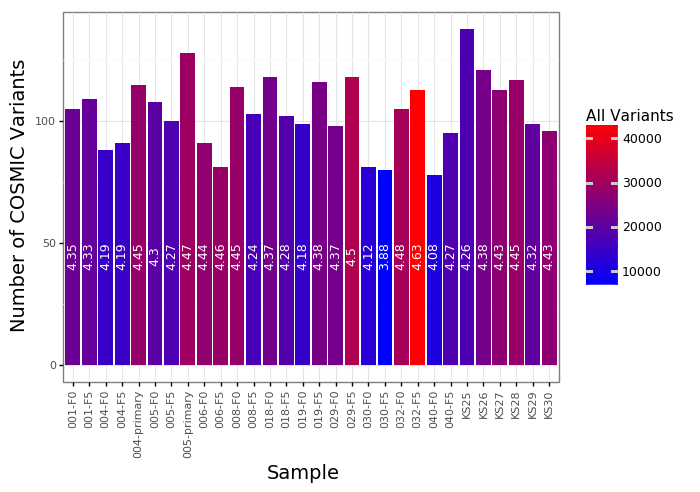

<ggplot: (-9223363260776607502)>

In [23]:
p = (
    gg.ggplot(filter_counts_df,
              gg.aes(x='sample_name', y='COSMIC_count', fill='filter_min_depth_count')) +
    gg.geom_bar(stat='identity', position='dodge') +
    # Note that the log mut count represents log10(total mutation count) in each sample
    gg.geom_text(gg.aes(y=45, label='log_mut_count', angle=90), size=9, colour='white') +
    gg.scale_fill_gradient(low='blue', high='red', name='All Variants') + 
    gg.xlab('Sample') +
    gg.ylab('Number of COSMIC Variants') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [24]:
figure_file = os.path.join('figures', 'merged_cosmic_mutcount_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.5 x 5.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: figures/merged_cosmic_mutcount_results.pdf
  warn('Filename: {}'.format(filename))
